# SQL Project : Online Course Platform Analysis

## Overview
This project analyzes student behavior and course performance on an online course platform using SQL and Python (SQLite). We explore patterns across enrollments, completions, course ratings, and more.

The objective is to extract insights such as:
- What are the most popular course categories?
- What is the gender distribution of students?
- Which courses have the highest enrollments?
- Which courses have the highest completion rates?
- What’s the average rating per course?
- How long does it take users to complete a course?
- How have enrollments changed month over month?
- What is the average price of top-rated vs. low-rated courses?
- Which locations have the most learners?
- What % of students complete at least one course?

---

### Dataset Tables

| Table         | Description                          |
|---------------|--------------------------------------|
| students      | Demographic data of users            |
| courses       | Course-level info (category, price)  |
| enrollments   | Course signups                       |
| completions   | Courses completed by users           |
| reviews       | Course ratings and feedback          |
    

In [7]:
import pandas as pd
import plotly.express as px
import sqlite3

In [2]:
# Load datasets
students     = pd.read_csv("data/students.csv")
courses      = pd.read_csv("data/courses.csv")
enrollments  = pd.read_csv("data/enrollments.csv")
completions  = pd.read_csv("data/completions.csv")
reviews      = pd.read_csv("data/reviews.csv")

# Preview datasets
print(students.head())
print(courses.head())

   user_id  gender  age location signup_date
0        1   Other   26    Delhi  2023-10-30
1        2  Female   35  Kolkata  2023-08-17
2        3  Female   51    Delhi  2023-10-11
3        4   Other   31  Chennai  2022-04-16
4        5   Other   32   Mumbai  2023-04-01
   course_id         category    instructor  price published_date
0          1         Business  Instructor 1    499     2021-09-08
1          2     Data Science  Instructor 2    499     2021-11-25
2          3     Data Science  Instructor 3   2499     2022-10-01
3          4  Web Development  Instructor 4    499     2022-05-28
4          5     Data Science  Instructor 5   1999     2022-10-09


In [3]:
# Connecting to SQLite (creating a new DB file locally)
conn = sqlite3.connect("course_platform.db")

# Loading dataframes into SQLite tables
students.to_sql("students", conn, if_exists="replace", index=False)
courses.to_sql("courses", conn, if_exists="replace", index=False)
enrollments.to_sql("enrollments", conn, if_exists="replace", index=False)
completions.to_sql("completions", conn, if_exists="replace", index=False)
reviews.to_sql("reviews", conn, if_exists="replace", index=False)

print("All tables loaded successfully into SQLite.")

All tables loaded successfully into SQLite.


In [4]:
# To Very Table Loading, Sample Query: List top 5 students
query = "SELECT * FROM students LIMIT 5;"
pd.read_sql(query, conn)

,user_id,gender,age,location,signup_date
0,1,Other,26,Delhi,2023-10-30
1,2,Female,35,Kolkata,2023-08-17
2,3,Female,51,Delhi,2023-10-11
3,4,Other,31,Chennai,2022-04-16
4,5,Other,32,Mumbai,2023-04-01


###  Query 1: Most Popular Course Categories

**What it does:**  
Counts the number of enrollments in each course category to identify what's in demand.

**What we get:**  
A ranked list of categories based on how many users enrolled in them.

**Business Insight:**  
Helps the company know which categories attract the most users — useful for marketing and deciding which new content to create.

In [5]:
query1 = """
SELECT c.category, COUNT(e.enrollment_id) AS total_enrollments
FROM enrollments e
JOIN courses c ON e.course_id = c.course_id
GROUP BY c.category
ORDER BY total_enrollments DESC;
"""
pd.read_sql(query1, conn)

,category,total_enrollments
0,Data Science,1621
1,Business,961
2,Web Development,856
3,Marketing,787
4,Design,775


## Query 2: Completion Rate per Course
Shows how many users completed each course and calculates the completion rate.

### Query 2: Completion Rate per Course

**What it does:**  
Calculates how many users enrolled vs how many actually completed each course, then gives a % completion rate.

**What we get:**  
Top courses with highest completion rates.

**Business Insight:**  
Shows which courses are most engaging or well-structured. High dropout? Maybe needs redesign.

In [6]:
query2 = """
SELECT 
    c.course_id,
    c.category,
    COUNT(DISTINCT e.user_id) AS enrolled,
    COUNT(DISTINCT comp.user_id) AS completed,
    ROUND(100.0 * COUNT(DISTINCT comp.user_id) / COUNT(DISTINCT e.user_id), 2) AS completion_rate
FROM courses c
JOIN enrollments e ON c.course_id = e.course_id
LEFT JOIN completions comp ON e.user_id = comp.user_id AND e.course_id = comp.course_id
GROUP BY c.course_id, c.category
ORDER BY completion_rate DESC
LIMIT 10;
"""
pd.read_sql(query2, conn)

,course_id,category,enrolled,completed,completion_rate
0,25,Marketing,106,75,70.75
1,9,Business,82,58,70.73
2,48,Web Development,93,65,69.89
3,32,Data Science,81,56,69.14
4,6,Data Science,98,67,68.37
5,11,Data Science,84,57,67.86
6,8,Marketing,93,63,67.74
7,33,Design,91,61,67.03
8,42,Data Science,108,72,66.67
9,45,Business,106,70,66.04


## Visualization: Top Course Categories by Enrollments

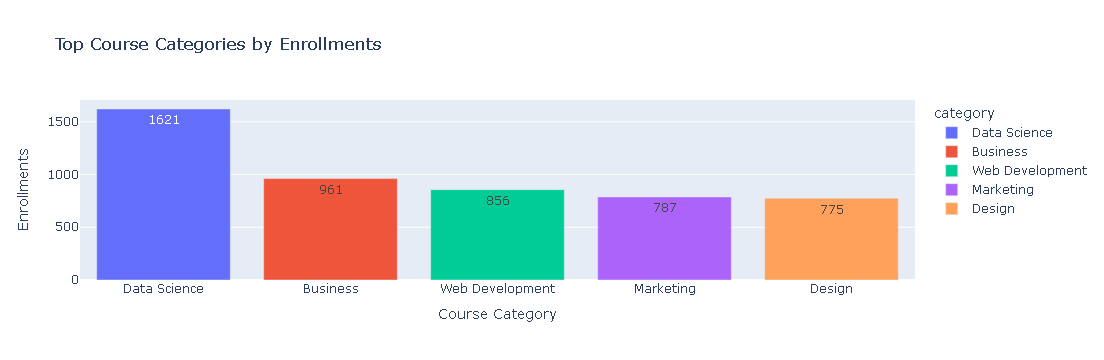

In [26]:
df_cat = pd.read_sql(query1, conn)

fig = px.bar(df_cat, x='category', y='total_enrollments',
             title='Top Course Categories by Enrollments',
             text='total_enrollments', color='category')
fig.update_layout(xaxis_title="Course Category", yaxis_title="Enrollments")
fig.write_image("charts/Top Course Categories by Enrollments.png", width=800, height=500)
fig.show()

### Query 3: Top Rated Courses

**What it does:**  
Computes average rating and number of reviews per course, and filters to courses with 10+ reviews for reliability.

**What we get:**  
List of top 10 highest-rated courses.

**Business Insight:**  
Reveals quality content and instructors. Can be featured or promoted.

In [9]:
query3 = """
SELECT 
    c.course_id,
    c.category,
    c.instructor,
    ROUND(AVG(r.rating), 2) AS avg_rating,
    COUNT(r.review_id) AS num_reviews
FROM courses c
JOIN reviews r ON c.course_id = r.course_id
GROUP BY c.course_id, c.category, c.instructor
HAVING COUNT(r.review_id) >= 10
ORDER BY avg_rating DESC
LIMIT 10;
"""
pd.read_sql(query3, conn)

,course_id,category,instructor,avg_rating,num_reviews
0,27,Web Development,Instructor 27,3.96,48
1,33,Design,Instructor 33,3.92,63
2,37,Data Science,Instructor 37,3.91,55
3,5,Data Science,Instructor 5,3.90,48
4,14,Data Science,Instructor 14,3.90,60
5,19,Marketing,Instructor 19,3.90,59
6,15,Web Development,Instructor 15,3.85,48
7,4,Web Development,Instructor 4,3.84,55
8,24,Marketing,Instructor 24,3.84,58
9,26,Business,Instructor 26,3.81,64


### Query 4: Monthly Enrollments Trend

**What it does:**  
Groups enrollments by month using SQLite date functions.

**What we get:**  
A time series showing how enrollments changed over time.

**Business Insight:**  
Helps detect seasonality or trend in learner sign-ups. Useful for planning campaigns.

In [10]:
query4 = """
SELECT 
    strftime('%Y-%m', enrollment_date) AS month,
    COUNT(*) AS enrollments
FROM enrollments
GROUP BY month
ORDER BY month;
"""
df_monthly = pd.read_sql(query4, conn)
df_monthly

,month,enrollments
0,2022-01,199
1,2022-02,165
2,2022-03,185
3,2022-04,214
4,2022-05,172
5,2022-06,208
6,2022-07,217
7,2022-08,207
8,2022-09,190
9,2022-10,206


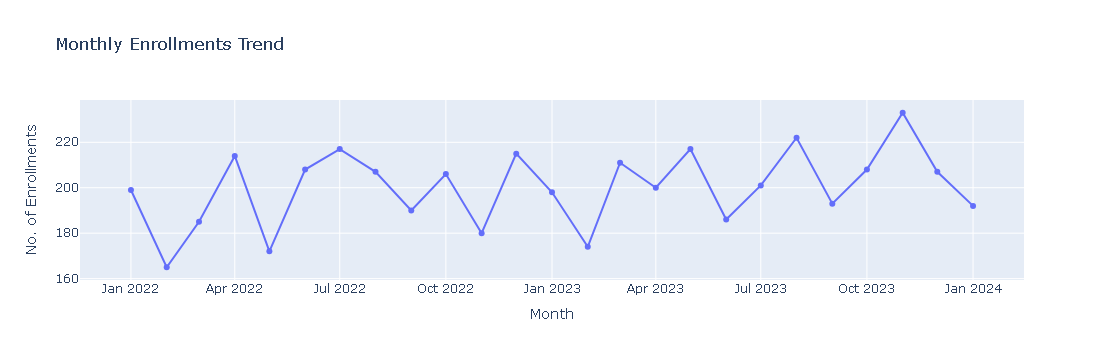

In [27]:
fig = px.line(df_monthly, x='month', y='enrollments',
              title='Monthly Enrollments Trend',
              markers=True)
fig.update_layout(xaxis_title="Month", yaxis_title="No. of Enrollments")
fig.write_image("charts/Monthly Enrollments Trend.png", width=800, height=500)
fig.show()

### Query 5: Student Locations Breakdown

**What it does:**  
Counts how many users belong to each city/location.

**What we get:**  
A list of cities ranked by number of students.

**Business Insight:**  
Identifies key markets and regions for targeted outreach or expansion.

In [12]:
query5 = """
SELECT location, COUNT(*) AS total_students
FROM students
GROUP BY location
ORDER BY total_students DESC;
"""
df_locations = pd.read_sql(query5, conn)
df_locations

,location,total_students
0,Chennai,214
1,Mumbai,212
2,Bangalore,203
3,Delhi,201
4,Kolkata,170


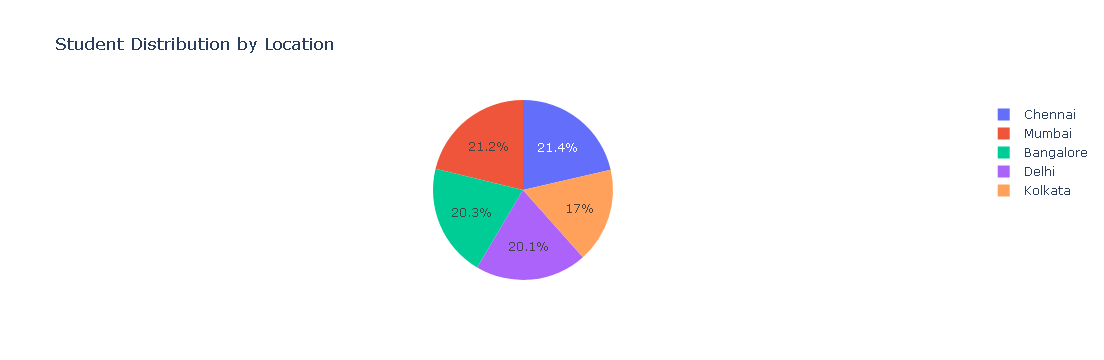

In [28]:
fig = px.pie(df_locations, names='location', values='total_students',
             title='Student Distribution by Location')
fig.write_image("charts/Student Distribution by Location.png", width=800, height=500)
fig.show()

### Query 6: Gender-wise Completion Rate

**What it does:**  
Breaks down completion % by gender.

**What we get:**  
Completion and dropout patterns across Male, Female, and Other.

**Business Insight:**  
Can inform personalized learning strategies and highlight gender-based engagement patterns.

In [14]:
query6 = """
SELECT 
    s.gender,
    COUNT(DISTINCT e.user_id) AS total_enrolled,
    COUNT(DISTINCT c.user_id) AS total_completed,
    ROUND(100.0 * COUNT(DISTINCT c.user_id) / COUNT(DISTINCT e.user_id), 2) AS completion_rate
FROM students s
JOIN enrollments e ON s.user_id = e.user_id
LEFT JOIN completions c ON s.user_id = c.user_id AND e.course_id = c.course_id
GROUP BY s.gender;
"""
pd.read_sql(query6, conn)

,gender,total_enrolled,total_completed,completion_rate
0,Female,362,343,94.75
1,Male,324,311,95.99
2,Other,310,297,95.81


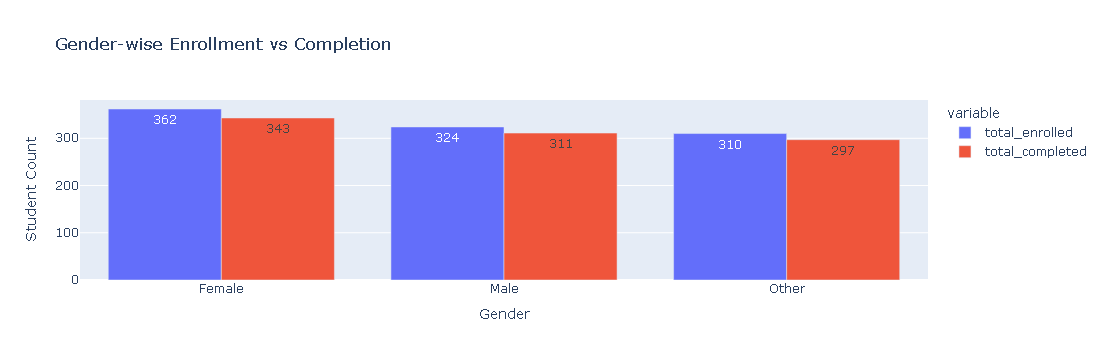

In [29]:
df_gender = pd.read_sql(query6, conn)
fig = px.bar(df_gender,
             x="gender",
             y=["total_enrolled", "total_completed"],
             barmode='group',
             text_auto=True,
             title="Gender-wise Enrollment vs Completion")
fig.update_layout(xaxis_title="Gender", yaxis_title="Student Count")
fig.write_image("charts/Gender-wise Enrollment vs Completion.png", width=800, height=500)
fig.show()

### Query 7: Dropout Rate by Course Category

**What it does:**  
Calculates how many users enrolled but did not complete courses, and gives % dropout.

**What we get:**  
Category-wise dropout insights.

**Business Insight:**  
Helps identify difficult or unengaging content areas that may need revamp or support.

In [15]:
query7 = """
SELECT 
    c.category,
    COUNT(DISTINCT e.user_id) AS enrolled,
    COUNT(DISTINCT comp.user_id) AS completed,
    (COUNT(DISTINCT e.user_id) - COUNT(DISTINCT comp.user_id)) AS dropped,
    ROUND(100.0 * (COUNT(DISTINCT e.user_id) - COUNT(DISTINCT comp.user_id)) / COUNT(DISTINCT e.user_id), 2) AS dropout_rate
FROM enrollments e
JOIN courses c ON e.course_id = c.course_id
LEFT JOIN completions comp 
    ON e.user_id = comp.user_id AND e.course_id = comp.course_id
GROUP BY c.category
ORDER BY dropout_rate DESC;
"""
pd.read_sql(query7, conn)

,category,enrolled,completed,dropped,dropout_rate
0,Design,544,367,177,32.54
1,Marketing,543,373,170,31.31
2,Web Development,568,396,172,30.28
3,Business,608,430,178,29.28
4,Data Science,797,623,174,21.83


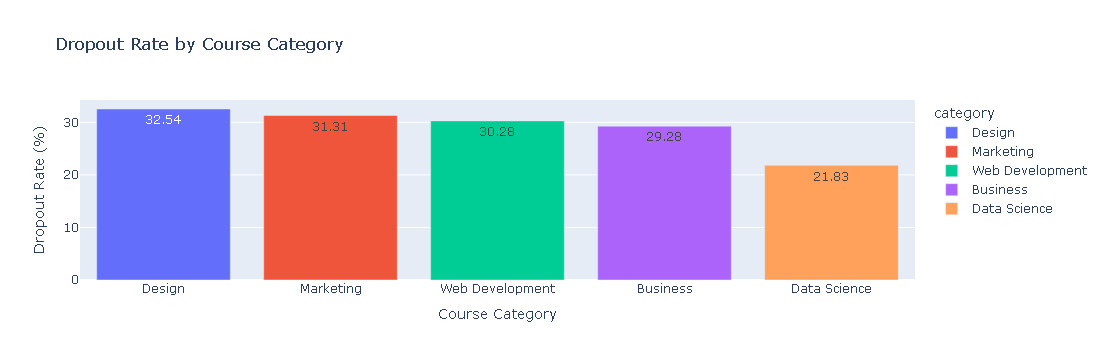

In [30]:
df_dropout = pd.read_sql(query7, conn)
fig = px.bar(df_dropout,
             x="category",
             y="dropout_rate",
             text="dropout_rate",
             color="category",
             title="Dropout Rate by Course Category")
fig.update_layout(xaxis_title="Course Category", yaxis_title="Dropout Rate (%)")
fig.write_image("charts/Dropout Rate by Course Category.png", width=800, height=500)
fig.show()

### Query 8: Total Revenue by Course Category

**What it does:**  
Estimates total revenue by multiplying enrollments with course prices for each category.

**What we get:**  
Ranked revenue contribution by each course category.

**Business Insight:**  
Pinpoints high-earning content areas and helps decide investment priorities.

In [16]:
query8 = """
SELECT 
    c.category,
    SUM(c.price) AS total_revenue,
    COUNT(e.enrollment_id) AS total_enrollments
FROM enrollments e
JOIN courses c ON e.course_id = c.course_id
GROUP BY c.category
ORDER BY total_revenue DESC;
"""
pd.read_sql(query8, conn)

,category,total_revenue,total_enrollments
0,Data Science,2755879,1621
1,Web Development,1446644,856
2,Design,1369225,775
3,Business,1255039,961
4,Marketing,951713,787


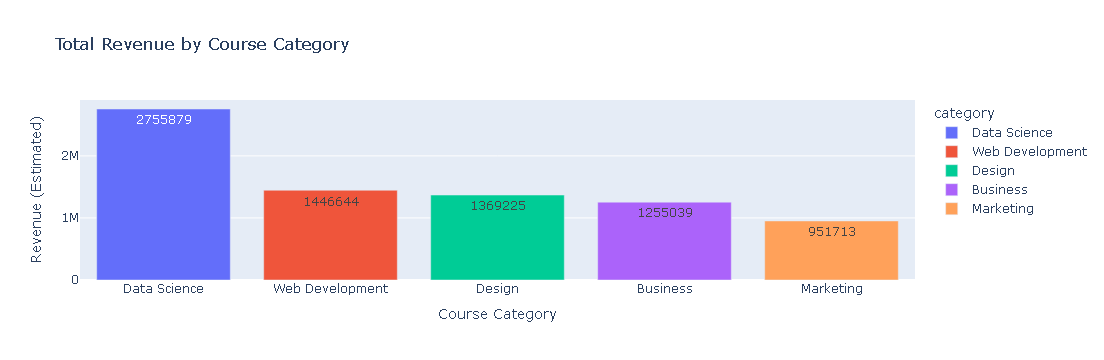

In [31]:
df_revenue = pd.read_sql(query8, conn)
fig = px.bar(df_revenue,
             x="category",
             y="total_revenue",
             color="category",
             text="total_revenue",
             title="Total Revenue by Course Category")
fig.update_layout(xaxis_title="Course Category", yaxis_title="Revenue (Estimated)")
fig.write_image("charts/Total Revenue by Course Category.png", width=800, height=500)
fig.show()

### Query 9: Top Performing Instructors

**What it does:**  
Counts enrollments per instructor and shows their average course rating.

**What we get:**  
Top instructors by popularity and student feedback.

**Business Insight:**  
Can help in recognition, bonuses, or assigning future course development.

In [17]:
query9 = """
SELECT 
    c.instructor,
    COUNT(e.enrollment_id) AS total_enrollments,
    ROUND(AVG(r.rating), 2) AS avg_rating
FROM enrollments e
JOIN courses c ON e.course_id = c.course_id
LEFT JOIN reviews r ON c.course_id = r.course_id
GROUP BY c.instructor
HAVING total_enrollments > 30
ORDER BY total_enrollments DESC
LIMIT 10;
"""
pd.read_sql(query9, conn)

,instructor,total_enrollments,avg_rating
0,Instructor 2,9017,3.56
1,Instructor 25,7881,3.68
2,Instructor 6,7704,3.64
3,Instructor 8,7700,3.55
4,Instructor 21,7632,3.19
5,Instructor 42,7524,3.70
6,Instructor 43,7215,3.60
7,Instructor 35,7154,3.71
8,Instructor 37,6930,3.91
9,Instructor 44,6912,3.64


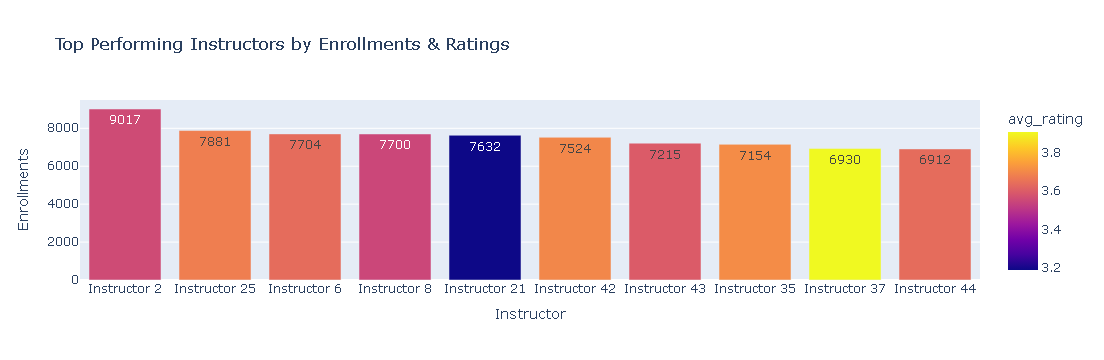

In [32]:
df_instructors = pd.read_sql(query9, conn)
fig = px.bar(df_instructors,
             x="instructor",
             y="total_enrollments",
             color="avg_rating",
             text="total_enrollments",
             title="Top Performing Instructors by Enrollments & Ratings")
fig.update_layout(xaxis_title="Instructor", yaxis_title="Enrollments")
fig.write_image("charts/Top Performing Instructors by Enrollments & Ratings.png", width=800, height=500)
fig.show()

### Query 10: Average Time to Course Completion

**What it does:**  
Calculates average number of days between enrollment and course completion.

**What we get:**  
Top 10 courses that are completed quickly — or are efficiently designed.

**Business Insight:**  
Useful for identifying fast-paced or well-structured courses vs those that may be too long or unclear.

In [24]:
query10 = """
SELECT 
    c.course_id,
    c.category,
    COUNT(*) AS completions,
    ROUND(AVG(
        JULIANDAY(comp.completion_date) - JULIANDAY(e.enrollment_date)
    ), 1) AS avg_days_to_complete
FROM completions comp
JOIN enrollments e 
  ON comp.user_id = e.user_id 
  AND comp.course_id = e.course_id
JOIN courses c 
  ON c.course_id = comp.course_id
WHERE JULIANDAY(comp.completion_date) > JULIANDAY(e.enrollment_date)
GROUP BY c.course_id, c.category
HAVING completions >= 5
ORDER BY avg_days_to_complete ASC
LIMIT 10;
"""
pd.read_sql(query10, conn)

,course_id,category,completions,avg_days_to_complete
0,24,Marketing,29,175.5
1,12,Design,23,198.1
2,28,Marketing,24,202.1
3,43,Web Development,35,203.7
4,29,Design,27,212.9
5,31,Design,21,215.9
6,33,Design,38,219.5
7,2,Data Science,34,225.1
8,18,Business,33,228.8
9,49,Business,32,235.1


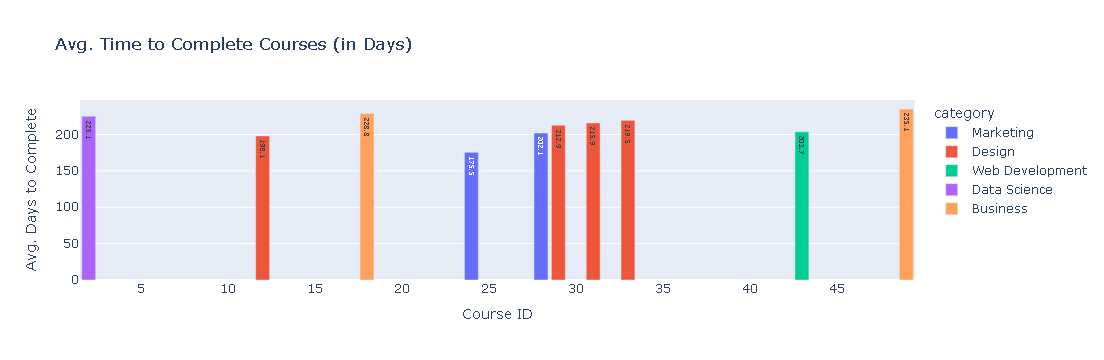

In [33]:
df_time = pd.read_sql(query10, conn)
fig = px.bar(df_time,
             x="course_id",
             y="avg_days_to_complete",
             color="category",
             text="avg_days_to_complete",
             title="Avg. Time to Complete Courses (in Days)")
fig.update_layout(xaxis_title="Course ID", yaxis_title="Avg. Days to Complete")
fig.write_image("charts/Avg. Time to Complete Courses (in Days).png", width=800, height=500)
fig.show()

In [34]:
conn.close()

## Final Conclusion

This SQL-based analysis explored the performance, engagement, and revenue metrics of an online course platform using a relational database containing students, courses, enrollments, reviews, and completions data.

Through 10 business-driven queries and data visualizations, we uncovered key insights such as:

- Most popular course categories by enrollments
- Completion rates and average time to completion across courses
- Top-rated and most engaging courses and instructors
- Revenue contribution by category
- Dropout patterns and user retention concerns
- Geographic and demographic engagement breakdown

The visualizations built using **Plotly** made it easier to communicate findings to stakeholders in a clear and interactive format.

This project demonstrates practical skills in:
- SQL (Joins, Aggregations, Grouping, Filtering, Date functions)
- Python (Data querying, cleaning, and visualization)
- Business storytelling with data

It simulates a real-world scenario where data analysts are expected to connect raw transactional data to meaningful business actions.